In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [3]:
# Load the data from the CSV file
df = pd.read_csv('/content/amazon_stock_price.csv')

In [4]:
# Convert the 'Date' column to datetime type
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
# Sort the DataFrame by date in ascending order
df = df.sort_values('Date')

In [6]:
# Extract the 'Close' column (our target variable)
dataset = df[['Close']].values.astype(float)

In [7]:
# Normalize the dataset using Min-Max scaling to bring values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
# Function to create input sequences and corresponding target values
def create_sequences(dataset, look_back=1):
    data_X, data_y = [], []
    for i in range(len(dataset) - look_back):
        data_X.append(dataset[i:(i + look_back), 0])
        data_y.append(dataset[i + look_back, 0])
    return np.array(data_X), np.array(data_y)

In [9]:
# Set the look-back period (number of previous time steps to use for prediction)
look_back = 30

In [10]:
# Create input sequences and target values
X, y = create_sequences(dataset, look_back)

In [11]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [12]:
# Reshape the input data to fit the LSTM input shape (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [13]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
4287/4287 - 21s - loss: 1.0084e-05 - 21s/epoch - 5ms/step
Epoch 2/100
4287/4287 - 14s - loss: 3.4736e-06 - 14s/epoch - 3ms/step
Epoch 3/100
4287/4287 - 15s - loss: 2.6222e-06 - 15s/epoch - 3ms/step
Epoch 4/100
4287/4287 - 15s - loss: 2.2404e-06 - 15s/epoch - 3ms/step
Epoch 5/100
4287/4287 - 14s - loss: 2.0190e-06 - 14s/epoch - 3ms/step
Epoch 6/100
4287/4287 - 14s - loss: 2.0103e-06 - 14s/epoch - 3ms/step
Epoch 7/100
4287/4287 - 14s - loss: 1.9650e-06 - 14s/epoch - 3ms/step
Epoch 8/100
4287/4287 - 15s - loss: 1.8073e-06 - 15s/epoch - 3ms/step
Epoch 9/100
4287/4287 - 15s - loss: 1.8052e-06 - 15s/epoch - 3ms/step
Epoch 10/100
4287/4287 - 14s - loss: 1.6952e-06 - 14s/epoch - 3ms/step
Epoch 11/100
4287/4287 - 14s - loss: 1.5117e-06 - 14s/epoch - 3ms/step
Epoch 12/100
4287/4287 - 14s - loss: 1.6446e-06 - 14s/epoch - 3ms/step
Epoch 13/100
4287/4287 - 14s - loss: 1.6566e-06 - 14s/epoch - 3ms/step
Epoch 14/100
4287/4287 - 15s - loss: 1.5561e-06 - 15s/epoch - 3ms/step
Epoch 15/100
42

In [15]:
# Generate predictions on the training and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

58/58 [==============================] - 0s 3ms/step


In [16]:
# Inverse transform the predictions to the original scale
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [17]:
# Calculate the root mean squared error (RMSE) to evaluate the model's performance
train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
print(f"Train RMSE: {train_score:.2f}")

Train RMSE: 5.14


In [18]:
test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
print(f"Test RMSE: {test_score:.2f}")

Test RMSE: 344.77


In [19]:
# Find the day with the highest and lowest closing value
max_close_day = df.loc[df['Close'].idxmax()]['Date']
min_close_day = df.loc[df['Close'].idxmin()]['Date']

print(f"Day with highest closing value: {max_close_day}")
print(f"Day with lowest closing value: {min_close_day}")

Day with highest closing value: 2021-07-08 00:00:00
Day with lowest closing value: 1997-05-22 00:00:00


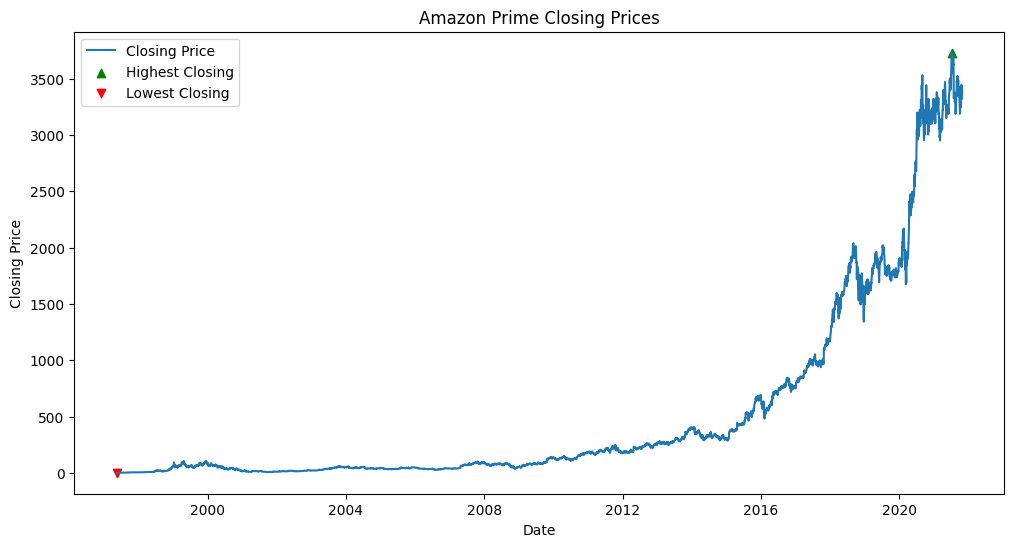

In [20]:
# Plot the historical closing prices over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Closing Price')
plt.scatter(max_close_day, df.loc[df['Close'].idxmax()]['Close'], color='green', label='Highest Closing', marker='^')
plt.scatter(min_close_day, df.loc[df['Close'].idxmin()]['Close'], color='red', label='Lowest Closing', marker='v')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Amazon Prime Closing Prices')
plt.legend()
plt.show()

In [21]:
# Calculate the rolling mean and standard deviation of the closing prices
rolling_mean = df['Close'].rolling(window=30).mean()
rolling_std = df['Close'].rolling(window=30).std()

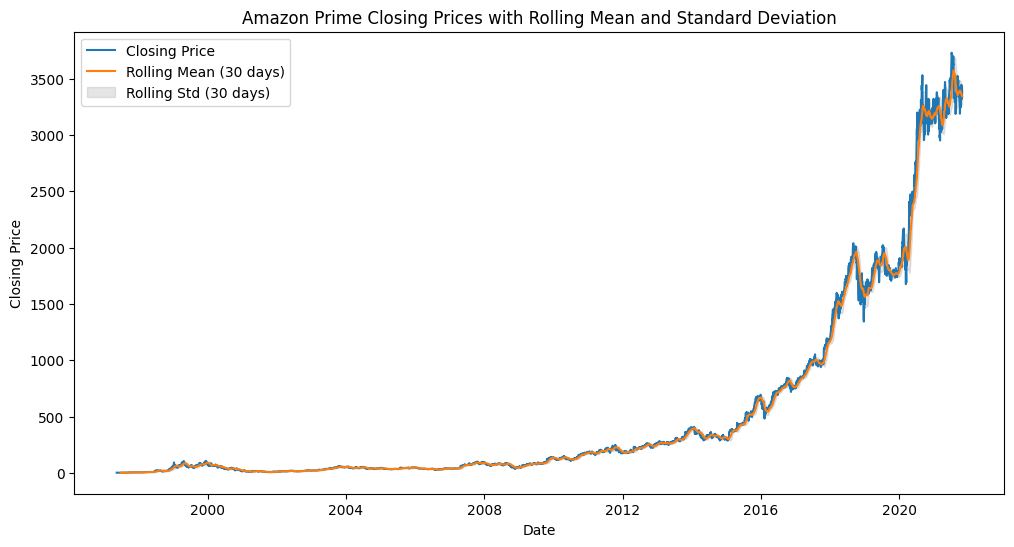

In [22]:
# Plot the rolling mean and standard deviation
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Closing Price')
plt.plot(df['Date'], rolling_mean, label='Rolling Mean (30 days)')
plt.fill_between(df['Date'], rolling_mean - rolling_std, rolling_mean + rolling_std, alpha=0.2, color='gray', label='Rolling Std (30 days)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Amazon Prime Closing Prices with Rolling Mean and Standard Deviation')
plt.legend()
plt.show()

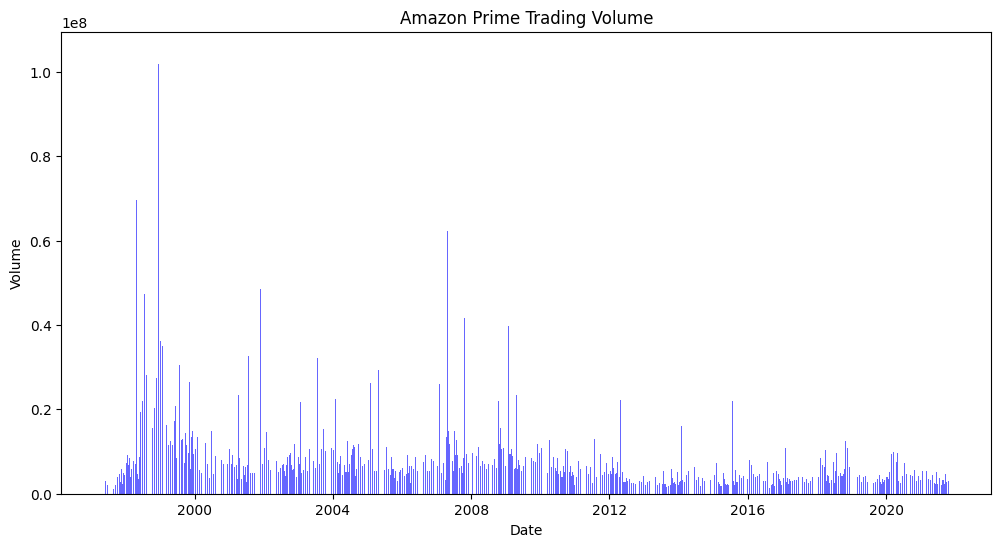

In [23]:
# Plot the trading volume over time
plt.figure(figsize=(12, 6))
plt.bar(df['Date'], df['Volume'], color='blue', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Amazon Prime Trading Volume')
plt.show()

In [24]:
# Extend the dataset to simulate future predictions (e.g., 30 days beyond the available data)
extended_dates = pd.date_range(start=df['Date'].max(), periods=30, freq='D')
extended_dates = pd.DataFrame({'Date': extended_dates})
extended_df = pd.concat([df, extended_dates], ignore_index=True)

In [25]:
# Preprocess the extended dataset for prediction
extended_dataset = scaler.transform(extended_df[['Close']].values.astype(float))
X_extended, y_extended = create_sequences(extended_dataset, look_back)
X_extended = np.reshape(X_extended, (X_extended.shape[0], X_extended.shape[1], 1))

In [26]:
# Generate predictions for the extended dataset
extended_predict = model.predict(X_extended)
extended_predict = scaler.inverse_transform(extended_predict)

193/193 [==============================] - 0s 2ms/step


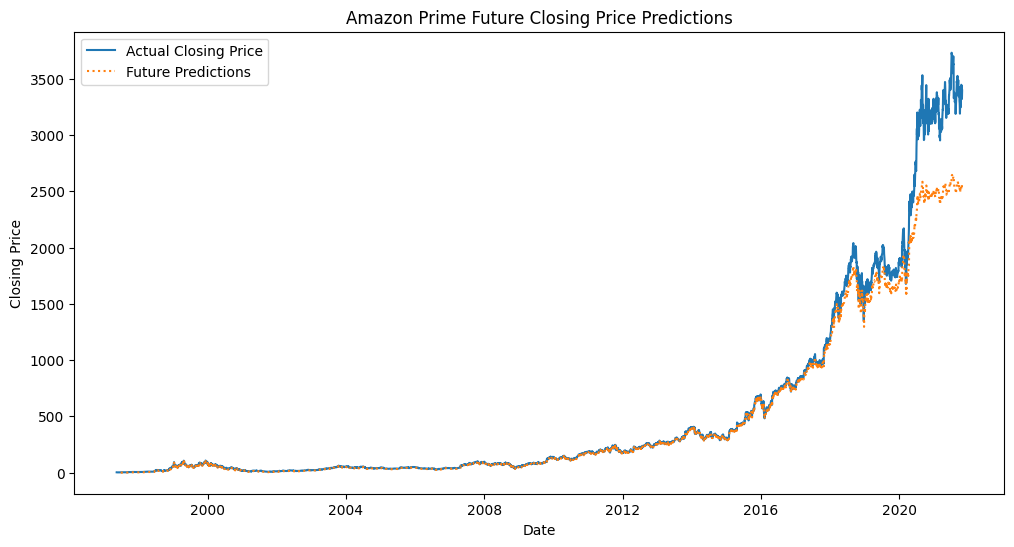

In [27]:
# Plot the actual data and future predictions
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Actual Closing Price')
plt.plot(extended_df.iloc[look_back:]['Date'], extended_predict, label='Future Predictions', linestyle='dotted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Amazon Prime Future Closing Price Predictions')
plt.legend()
plt.show()

In [37]:
# Filter the data for the year 2020
df_2020 = df[df['Date'].dt.year == 2020]

# Create a DataFrame for actual and predicted closing prices in 2020
dates_2020 = df_2020['Date'][look_back + 1:].reset_index(drop=True)  # Adjusted indexing
actual_prices_2020 = df_2020['Close'][look_back:-1].reset_index(drop=True)  # Adjusted indexing
predicted_prices_2020 = extended_predict[-len(dates_2020):].flatten()  # Flattening the predicted prices array

closing_prices_2020_df = pd.DataFrame({'Date': dates_2020, 'Actual': actual_prices_2020, 'Predicted': predicted_prices_2020})

# Display the actual and predicted closing prices for the year 2020 in a tabular form
print(closing_prices_2020_df)

          Date       Actual    Predicted
0   2020-02-18  2134.870117  2511.926270
1   2020-02-19  2155.669922  2519.838623
2   2020-02-20  2170.219971  2504.669678
3   2020-02-21  2153.100098  2498.729492
4   2020-02-24  2095.969971  2489.710449
..         ...          ...          ...
217 2020-12-24  3185.270020          NaN
218 2020-12-28  3172.689941          NaN
219 2020-12-29  3283.959961          NaN
220 2020-12-30  3322.000000          NaN
221 2020-12-31  3285.850098          NaN

[222 rows x 3 columns]


In [28]:
# Calculate the 50-day and 200-day moving averages
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['MA_200'] = df['Close'].rolling(window=200).mean()

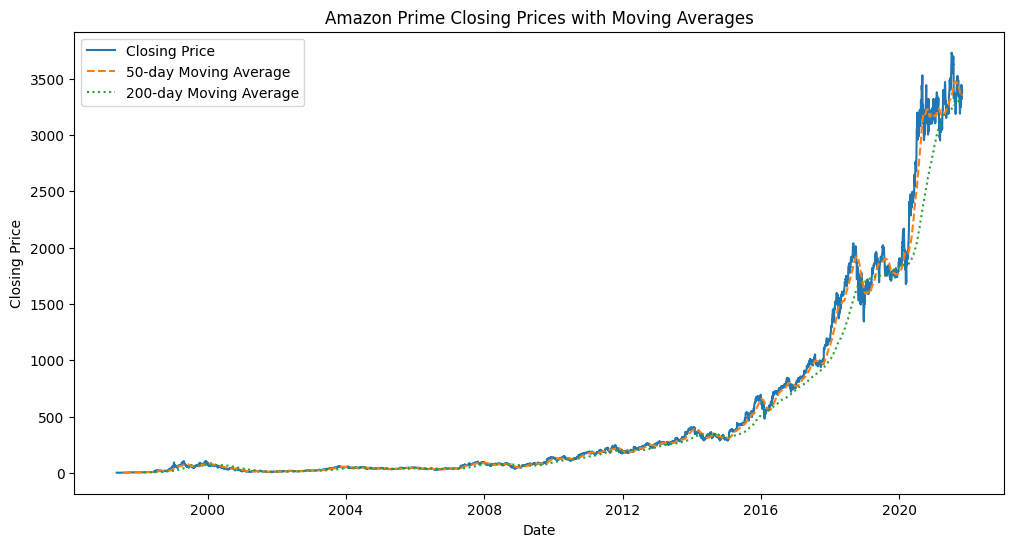

In [29]:
# Plot the moving averages
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Closing Price')
plt.plot(df['Date'], df['MA_50'], label='50-day Moving Average', linestyle='dashed')
plt.plot(df['Date'], df['MA_200'], label='200-day Moving Average', linestyle='dotted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Amazon Prime Closing Prices with Moving Averages')
plt.legend()
plt.show()